<a href="https://colab.research.google.com/github/carol-furtado/Denoising-and-image-classification/blob/main/Image_Denoising_%26_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [3]:
from google.colab import files
uploaded = files.upload()


Saving train.zip to train (1).zip


In [4]:
import zipfile

with zipfile.ZipFile("train.zip", 'r') as zip_ref:
    zip_ref.extractall("train")


In [5]:
!ls /content


 sample_data   train  'train (1).zip'   train.zip


In [6]:
data_dir_clean = "/content/train/train/clean"
data_dir_noisy = "/content/train/train/noisy"
normalization_layer = tf.keras.layers.Rescaling(1./255)

clean = tf.keras.utils.image_dataset_from_directory(
    data_dir_clean,
    labels=None,

    image_size=(224,224),
    batch_size=32,
    shuffle=False
).map(lambda x: (normalization_layer(x)))


noisy = tf.keras.utils.image_dataset_from_directory(
    data_dir_noisy,
    labels=None,

    image_size=(224,224),
    batch_size=32,
    shuffle=False
).map(lambda x: (normalization_layer(x)))


Found 1795 files.
Found 1795 files.


In [7]:
import numpy as np

# Convert TF dataset to numpy array (no labels since label_mode=None)
def dataset_to_numpy(dataset):
    images = []
    for batch in dataset:
        images.append(batch.numpy())   # each batch is a tensor of shape (batch_size, h, w, c)
    return np.concatenate(images, axis=0)

# Example
clean_train_images = dataset_to_numpy(clean)
noisy_train_images = dataset_to_numpy(noisy)

print(clean_train_images.shape)
print(noisy_train_images.shape)


(1795, 224, 224, 3)
(1795, 224, 224, 3)


In [32]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class DenoisingAutoencoder(Model):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(224, 224, 3)),
            layers.Conv2D(64, (3,3), activation='relu', padding='same'),
            layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2), # 112x112
            layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2), # 56x56
            layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=2), # 28x28
            layers.Conv2D(512, (3,3), activation='relu', padding='same'),
            layers.Conv2D(512, (3,3), activation='relu', padding='same', strides=2)  # 14x14
        ])

        # Decoder (mirrors encoder)
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(512, (3,3), strides=2, activation='relu', padding='same'), # 28x28
            layers.Conv2DTranspose(256, (3,3), strides=2, activation='relu', padding='same'), # 56x56
            layers.Conv2DTranspose(128, (3,3), strides=2, activation='relu', padding='same'), # 112x112
            layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same'),  # 224x224
            layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')  # Output layer
        ])

    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded


In [9]:

import tensorflow.image as tfi

def psnr_metric(y_true, y_pred):
    return tfi.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tfi.ssim(y_true, y_pred, max_val=1.0)


In [33]:

#compile

autoencoder = DenoisingAutoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss=tf.keras.losses.MeanAbsoluteError(),
                    metrics=[psnr_metric, ssim_metric])



In [ ]:
history = autoencoder.fit(
    x=tf.convert_to_tensor(noisy_train_images, dtype=tf.float32),
    y=tf.convert_to_tensor(clean_train_images, dtype=tf.float32),
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/10
 1/45 ━━━━━━━━━━━━━━━━━━━━ 34:22 47s/step - loss: 0.2774 - psnr_metric: 10.3535 - ssim_metric: 0.3393

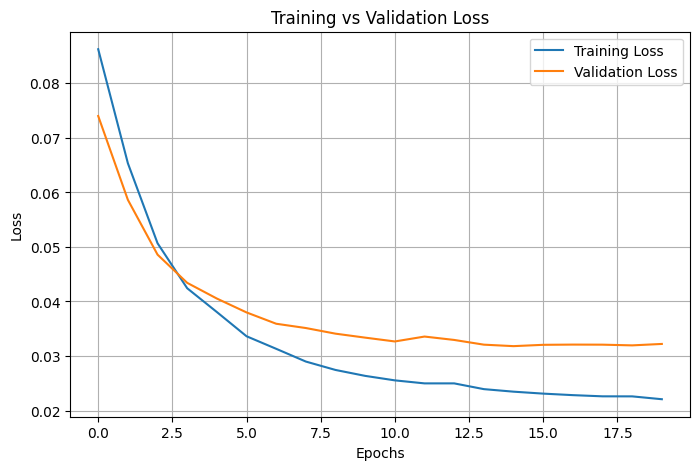

In [12]:
#plotting training vs validation loss
plt.figure(figsize=(8,5))

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#now im gonna load test images dataset to evaluate model performance
from google.colab import files
uploaded = files.upload()


Saving test.zip to test.zip


In [16]:
import zipfile

with zipfile.ZipFile("test.zip", 'r') as zip_ref:
    zip_ref.extractall("test")


In [23]:
test_dir = "/content/test/test/noisy"
normalization_layer = tf.keras.layers.Rescaling(1./255)


# Load noisy test images
noisy_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels=None,              # No labels, just images
    image_size=(224, 224),      # 👈 change to your image size
    color_mode="rgb",   # or "rgb" if your dataset is in color
    batch_size=32,
    shuffle=False             # keep order consistent
).map(lambda x: (normalization_layer(x)))

# Convert dataset to numpy array
def dataset_to_numpy(dataset):
    images = []
    for batch in dataset:
        images.extend(batch.numpy())
    return np.array(images)

noisy_test_images = dataset_to_numpy(noisy_test_ds)


Found 772 files.


25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 622ms/step


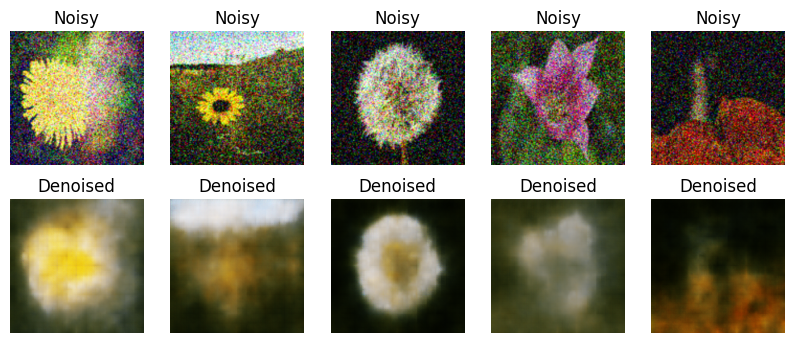

In [31]:
# Predict denoised images from noisy test set
denoised_test_images = autoencoder.predict(noisy_test_images)

import matplotlib.pyplot as plt
import numpy as np



n = 5  # number of samples to visualize
plt.figure(figsize=(10, 4))

for i in range(n):
    # Noisy input
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noisy_test_images[i])
    plt.title("Noisy")
    plt.axis("off")

    # Denoised output
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(denoised_test_images[i])
    plt.title("Denoised")
    plt.axis("off")

plt.show()
